In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pltconfig import *

In [2]:
# Load bioreactor data 

# Culture density data from bioreactor pumping ambient air from 08/31/19.
# Note: first 19 rows are metadata for the experiment.
bioreactor_continuous_df = pd.read_csv('data/fig3/083119_CCMB1_bioreactor_continuous.csv', skiprows=19)
# Column names have whitespace off the machine - fix manually.
bioreactor_continuous_df.columns = [x.strip() for x in bioreactor_continuous_df.columns]

In [3]:
# Mapping of names to specific bioreactor tube labels.
bioreactor_mapping = {'recon.1': 'od-sensors-1.od-680 ',
                      'recon.2': 'od-sensors-2.od-680 ',
                      'recon.4': 'od-sensors-3.od-680 ',
                      'K194M.3': 'od-sensors-4.od-680 ',
                      'K194M.4': 'od-sensors-5.od-680 ',
                      'lsPrk.3': 'od-sensors-6.od-680 ',
                      'lsPrk.4': 'od-sensors-7.od-680 ',
                      'pos': 'od-sensors-8.od-680 ',
                     }

# Which ones to plot and colors for them.
bioreactor_names2plot = {'recon.4': purples[-2],
                         'lsPrk.3': greens[-2]}

In [4]:
# Endpoint data from 08/31/19 spark experiment. Produced from continuous data, endpoint is 80h. 
spark_endpoint_df = pd.read_csv('data/fig3/083119_CCMB1_ambient_OD80hrs_spark_blanked.csv', index_col=0, skipinitialspace=True)

# Groupings of samples for plotting spark endpoint data
all_names = spark_endpoint_df.replicate.unique()
exp = [c for c in all_names if c.startswith('rec')]
neg = [c for c in all_names if c.startswith('K194')]
neg_exp = [c for c in all_names if c.startswith('ls')]

# Colors to use for the spark endpoint data
replicates_palette = {}
replicates_palette.update([(n, greys[-2*i-1]) for i, n in enumerate(neg)])
replicates_palette.update([(n, greens[-2*i-1]) for i, n in enumerate(neg_exp)])
replicates_palette.update([(n, purples[-2*i-1]) for i, n in enumerate(exp)])

In [5]:
# Load precomputed flux predictions via pFBA
flux_prediction_df = pd.read_csv('data/FBA/ccmb1_fluxes.csv')
rub_pct_range = (flux_prediction_df.rub_pct_3pg_prod.min(), flux_prediction_df.rub_pct_3pg_prod.max())

# Load precomputed flux inferences (from data).
flux_inference_df = pd.read_csv('data/LCMS/022720_flux_inferrence.csv')
flux_inference_df['pct_12co2_inferred'] = flux_inference_df.f12co2_inferred*100
flux_inference_df['ser_pct12c'] = flux_inference_df.ser_f12c*100

flux_inference_df

,sample,sample_name,ser_f12c,val_f12c,his_f12c,rel_rubisco_3PG_flux,f12co2_inferred,description,pct_12co2_inferred,ser_pct12c
0,AF 1,CAfree_bioreactor,0.004527,0.008098,0.008240,NaN,0.222829,"Control ambient air, bioreactor - CAfree:pFE-s...",22.282937,0.452685
1,AF 2,CAfree_bioreactor,0.008998,0.005226,0.005176,NaN,0.240664,"Control ambient air, bioreactor - CAfree:pFE-s...",24.066412,0.899821
2,AF 3,CAfree_bioreactor,0.003495,0.005430,0.007714,NaN,0.230044,"Control ambient air, bioreactor - CAfree:pFE-s...",23.004394,0.349472
3,AF 4,CAfree_bioreactor,0.007835,0.005119,0.000000,NaN,0.307965,"Control ambient air, bioreactor - CAfree:pFE-s...",30.796546,0.783520
4,AF 5,CCMB1_bioreactor,0.024767,0.012526,0.014273,0.276332,0.409055,Experiment ambient air bioreactor - CCMB1:pCB'...,40.905533,2.476675
5,AF 6,CCMB1_bioreactor,0.028638,0.025383,0.007746,0.149038,0.908982,Experiment ambient air bioreactor - CCMB1:pCB'...,90.898214,2.863817
6,AF 7,CCMB1_bioreactor,0.072608,0.020543,0.000000,0.441850,0.907794,Experiment ambient air bioreactor - CCMB1:pCB'...,90.779382,7.260753
7,AF 8,CCMB1_bioreactor,0.013666,0.008420,0.003346,0.101784,0.445492,Experiment ambient air bioreactor - CCMB1:pCB'...,44.549228,1.366569
8,AF 9,CAfree_10pct_incubator,0.019965,0.011921,0.011318,NaN,0.707723,"Control 10% CO2 incubator, round bottom tube -...",70.772304,1.996484
9,AF 10,CAfree_10pct_incubator,0.027541,0.017212,0.000000,NaN,0.803494,"Control 10% CO2 incubator, round bottom tube -...",80.349431,2.754077


/Users/flamholz/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


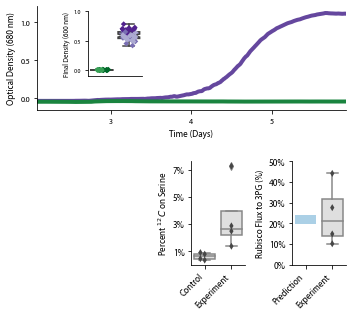

In [6]:
fig = plt.figure(figsize=(5, 4.5))

gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[2, 1, 1])

# bioreactor growth curves
ax0 = fig.add_subplot(gs[0, :])

for name, color in bioreactor_names2plot.items():
    # 'key' is the name of the measurement/well we are looking at. 
    key = bioreactor_mapping[name]
    my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]
    
    times = my_tube.time.values
    ods = pd.Series(my_tube.value.values)
    median_filtered_ods = ods.rolling(5).median()
    smoothed_ods = median_filtered_ods.rolling(10).mean()
    plt.plot(times, smoothed_ods, lw=4, color=color)

plt.xticks(np.arange(0, 144, 24), np.arange(0, 144, 24)//24, fontsize=8)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=8)

plt.xlim(50, 142)
plt.ylim(-0.15, 1.21)

# hide xlabel for illustrator
plt.xlabel('Time (Days)', fontsize=9)
plt.ylabel('Optical Density (680 nm)', fontsize=9)
sns.despine(ax=ax0)

# Inset for replicated endpoint data from the plate reader
axins = inset_axes(ax0, width=0.75, height=0.9, loc=2,
                   bbox_to_anchor=(.15, .5, .6, .5),
                   bbox_transform=ax0.transAxes)


pal = {'Full CCM': purples[-3], 'Rub. alone': greens[-3], 'Neg.': greys[-3]}
sns.boxplot(data=spark_endpoint_df, x='sample', y='OD', order=('Rub. alone', 'Full CCM'), ax=axins,
            whis=np.inf, palette=pal, notch=True)
sns.stripplot(data=spark_endpoint_df, x='sample', y='OD', order=('Rub. alone', 'Full CCM'), ax=axins,
              palette=replicates_palette, size=4, hue='replicate', jitter=0.25, marker='D', edgecolor='black')

plt.legend().set_visible(False)

plt.ylim(-0.1, 1.0)
plt.xticks([])
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=6)
plt.ylabel('Final Density (600 nm)', fontsize=7)
plt.xlabel('', fontsize=7)
sns.despine(ax=axins)

# plot %12C on serine
ax1 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[1])
sns.swarmplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[-2], marker='d')

yticks = np.arange(1, 7.1, 2)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax1.set_ylabel('Percent $^{12}C$ on Serine', fontsize=9)
ax1.set_xlabel('')
sns.despine(ax=ax1)

# Estimated flux through rubisco as compared to FBA predictions
ax2 = fig.add_subplot(gs[1, 2])

inferred_rub_flux = (flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor'].rel_rubisco_3PG_flux*100).values.tolist()
n_exps = len(inferred_rub_flux)

# TODO - actually use prediction here.
width = 0.8
xy = (-width/2, rub_pct_range[0])
height = rub_pct_range[1] - rub_pct_range[0]
fba_rect = plt.Rectangle(xy, width, height, facecolor=blues[2])
ax2.add_patch(fba_rect)

sns.boxplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[1])
sns.swarmplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[-2], marker='d')

yticks = np.arange(0, 51, 10)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],['Prediction', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Rubisco Flux to 3PG (%)', fontsize=9)
ax2.set_xlabel('')
ax2.set_ylim(0, 50)
ax2.set_xlim(-0.5, 1.5)
sns.despine(ax=ax2)

plt.tight_layout(h_pad=2)

plt.savefig('fig3/fig3.png', dpi=600)
plt.show()
